# Lec04-Pandas example:
- a) Using Pandas with multindexes to manipulate well logs. 
- b) Interpolation with scikit-learn.

In this notebook we will apply Pandas to read and visualize a series of well logs. \
The information from the logs is stored as a json file (download the json file from D2L). \
JSON (JavaScript Object Notation is an open standard file format and data interchange format that uses human-readable text to store and transmit data objects consisting \
of attribute–value pairs and arrays (or other serializable values). This notebook, for example, is a JSON file.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/WellLogsExample.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
from time import time
from os import getenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

First we need to read the data. For this problem, we were given a compressed json file that contains a series of geophysical attributes corresponding to the well logs. panda has a read_json method, and it allows to decompress the file (gunzip) during reading. We also will set two indexes, well_id as primary and two way traveltime (twt) as secondary. 

In [2]:
path = 'poseidon_geoml_training_wells.json.gz'
start_time = time()
well_data = pd.read_json(
    path_or_buf=path,
    compression='gzip'  #storage_options=s3_options,
)
print(f"Completed read in {time() - start_time:.2f} seconds")


Completed read in 0.18 seconds


In [3]:
well_data.head()

,well_id,twt,tvdss,inline,xline,gamma,rshal,rdeep,nphi,cal,rhob,dtc,dts
0,well_01,1136.5,2798.4675,2992.8834,2202.6259,8.6726,3.7827,2.2789,NaN,NaN,NaN,58.3867,NaN
1,well_01,1137.0,2798.4723,2992.8834,2202.6259,8.6323,3.7982,2.2860,NaN,NaN,NaN,58.4215,NaN
2,well_01,1137.5,2798.4771,2992.8834,2202.6258,8.5921,3.8136,2.2931,NaN,NaN,NaN,58.4564,NaN
3,well_01,1138.0,2798.4819,2992.8834,2202.6258,8.5518,3.8290,2.3002,NaN,NaN,NaN,58.4912,NaN
4,well_01,1138.5,2798.4867,2992.8834,2202.6258,8.5115,3.8445,2.3073,NaN,NaN,NaN,58.5260,NaN


In [4]:
well_data.set_index(['well_id', 'twt'], inplace=True)

In [5]:
well_data.head()

tvdss     inline      xline   gamma   rshal   rdeep  nphi  \
well_id twt                                                                     
well_01 1136.5  2798.4675  2992.8834  2202.6259  8.6726  3.7827  2.2789   NaN   
        1137.0  2798.4723  2992.8834  2202.6259  8.6323  3.7982  2.2860   NaN   
        1137.5  2798.4771  2992.8834  2202.6258  8.5921  3.8136  2.2931   NaN   
        1138.0  2798.4819  2992.8834  2202.6258  8.5518  3.8290  2.3002   NaN   
        1138.5  2798.4867  2992.8834  2202.6258  8.5115  3.8445  2.3073   NaN   

                cal  rhob      dtc  dts  
well_id twt                              
well_01 1136.5  NaN   NaN  58.3867  NaN  
        1137.0  NaN   NaN  58.4215  NaN  
        1137.5  NaN   NaN  58.4564  NaN  
        1138.0  NaN   NaN  58.4912  NaN  
        1138.5  NaN   NaN  58.5260  NaN

The pd.head() method shows we have 11 features (columns) and two indexes. You can display the features using the method pd.keys().

In [6]:
features=list(well_data.keys())
print(features)
print(len(features))

['tvdss', 'inline', 'xline', 'gamma', 'rshal', 'rdeep', 'nphi', 'cal', 'rhob', 'dtc', 'dts']
11


Because we set two indexes, we can access them using pd.index.levels[0] or [1]. For example:

In [7]:
well_data.index.levels[0]

Index(['well_01', 'well_11', 'well_21', 'well_25', 'well_27', 'well_33'], dtype='object', name='well_id')

In [8]:
well_data.index.levels[1]

Float64Index([1136.5, 1137.0, 1137.5, 1138.0, 1138.5, 1139.0, 1139.5, 1140.0,
              1140.5, 1141.0,
              ...
              3421.5, 3422.0, 3422.5, 3423.0, 3423.5, 3424.0, 3424.5, 3425.0,
              3425.5, 3426.0],
             dtype='float64', name='twt', length=4580)

We want the wells, index 0, so lets take them from pandas and put in a list that we can iterate through.

In [9]:
wells=list(well_data.index.levels[0])

In [10]:
print(wells)

['well_01', 'well_11', 'well_21', 'well_25', 'well_27', 'well_33']


Now let us plot the logs. We iterate though each well in the list wells, create a figure for each well, and access the last 8 features (columns). Before the last 8 features, we have coordinates that we don't need to plot the contents of the logs. Notice how we use pd.loc[well] to access the entries by primary index. We take all the different features and put them in another Dataframe called curves. Each new dataframe contains a different number of entries but all have the same 8 features we selected. 

In [11]:
for well in wells:        
    curves=well_data.loc[well][features[-8:]]
    print(type(curves), curves.shape)

<class 'pandas.core.frame.DataFrame'> (4399, 8)
<class 'pandas.core.frame.DataFrame'> (1839, 8)
<class 'pandas.core.frame.DataFrame'> (2549, 8)
<class 'pandas.core.frame.DataFrame'> (2031, 8)
<class 'pandas.core.frame.DataFrame'> (2776, 8)
<class 'pandas.core.frame.DataFrame'> (1230, 8)


Another interesting part of this plot is the use of python enumerate function to obtain an index for each plot. We want to create a different plot for each well, each with 8 subplots (one per feature). The panda method "pd.columns" is giving us each of the 8 features we want to plot. From enumerate we obtain the index and the curve for each plot. Finally, notice the use of the index method for each curve sub dataframe. This is the TWT, which was the second index for the full dataframe, but the first for each sub dataframe inside. 

Notice how the hierchachical indexing provides a way to work in multiple dimensions. Think of the plot below as a 3D volume (well, TWT, feature).

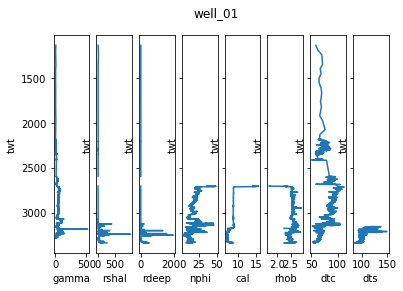

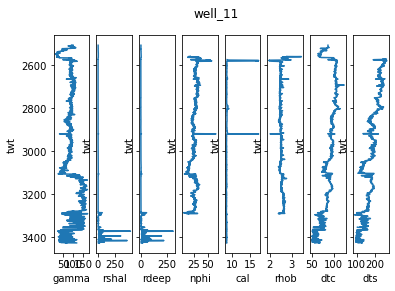

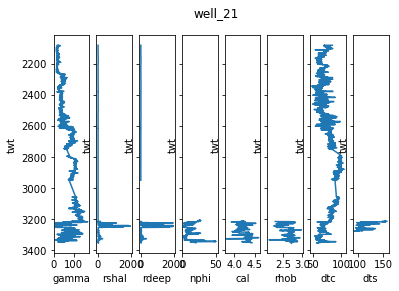

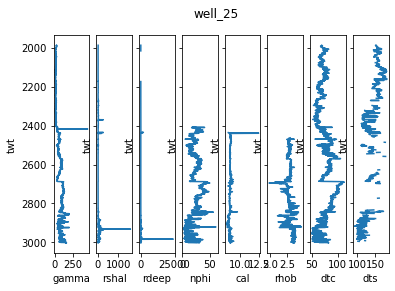

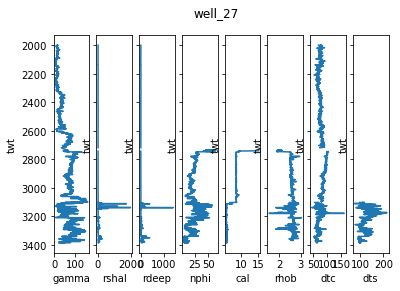

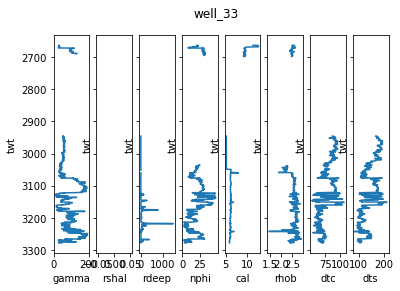

In [12]:
for well in wells:    
    fig, axes = plt.subplots(1,8,sharey='all')
    curves=well_data.loc[well][features[-8:]]
    fig.suptitle(well)
    #print(curves.shape)
    for idx,curve in enumerate(curves.columns):
        #print(idx, curve, well_data.loc[well][curve].shape)
        axes[idx].plot(curves[curve],curves[curve].index)
        axes[idx].set_ylabel(curves[curve].index.name)
        axes[idx].set_xlabel(curves[curve].name)
    axes[0].invert_yaxis()

## Imputation (interpolation)
AS you see, there are some missing parts of these curves. Most applications would require complete logs. Interpolation from different features in the ML literature is called "imputation". The task we will take on now is to interpolate the following features below.

In [13]:
selfeatures = ['gamma','dtc', 'dts','rhob']

The interpolation could be done in different ways. A reasonable approach would be to interpolate one, then add it into our data as it were all original and use it for the next one, and so on. This would require a few lines of code but, as usual, scikit-learn makes it easier for us. We have the a class called "IterativeInputer" that perform this automatically. We just need to tell it what method we want. Here we will use the ExtraTressRegressor. We will do all by parts first for clarity, then put all together.
The class IterativeInputer can fit the data, transform them, and give us back a NumpyArray.

In [14]:
imputer=IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
    missing_values=np.nan, 
    sample_posterior=False,
    max_iter = 20,
    tol=0.001)
print(type(imputer))

<class 'sklearn.impute._iterative.IterativeImputer'>


In [15]:
for well in wells[:1]:
    tmp = well_data.loc[well][selfeatures]
    print(type(tmp), tmp.shape)
    well_fill=imputer.fit_transform(tmp)
    print(type(well_fill), well_fill.shape)

<class 'pandas.core.frame.DataFrame'> (4399, 4)
<class 'numpy.ndarray'> (4399, 4)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


So the inputer has created a numpy array with the features filled in.\
We want to use plotting functions from pd, so we will put each numpy array into a dataframe to plot just as we did before for curves. 

(4399, 4)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(1839, 4)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(2549, 4)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(2031, 4)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(2776, 4)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


(1230, 4)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


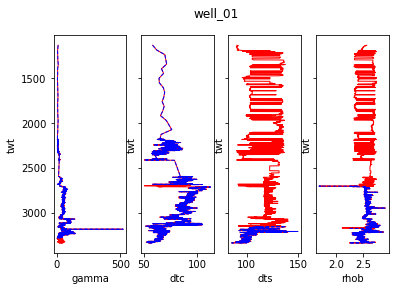

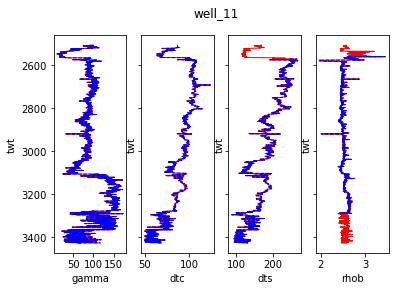

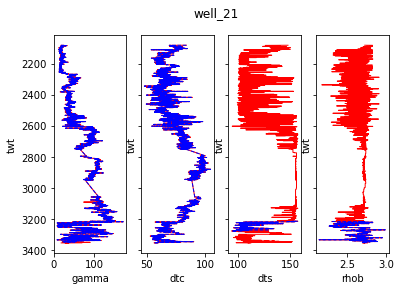

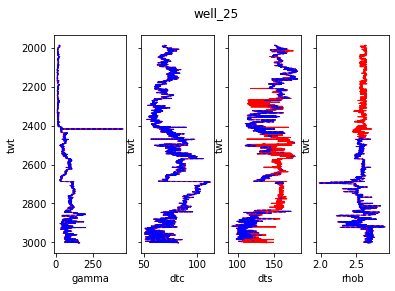

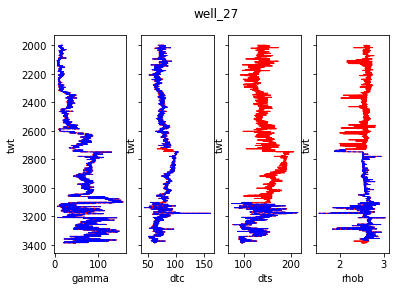

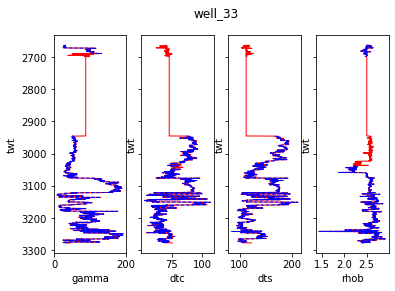

In [16]:
# the imputer could be created directly inside the loop, 
# but this is clearer to show each feature adds to the same imputer

imputer = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
    missing_values=np.nan, 
    sample_posterior=False,
    max_iter = 20,
    tol=0.001
)
for well in wells:
    tmp=well_data.loc[well][selfeatures]
    print(tmp.shape)
    well_fill = imputer.fit_transform(tmp)
    well_fill = pd.DataFrame(well_fill, columns = selfeatures)
    fig, ax = plt.subplots(1,4,sharey='all')
    curves = well_data.loc[well][selfeatures]
    fig.suptitle(well)
    for idx, curve in enumerate(curves.columns):
        ax[idx].plot(well_fill[curve],curves[curve].index,marker='',color='red',linewidth=1)
        ax[idx].plot(curves[curve], curves[curve].index, marker='', color='blue', linewidth=1, linestyle='dashed')
        ax[idx].set_ylabel(curves[curve].index.name)
        ax[idx].set_xlabel(curves[curve].name)
    ax[0].invert_yaxis()